In [2]:
import tensorflow

In [3]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
from tensorflow.keras import regularizers
import numpy as np
%matplotlib inline

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data() # we don't need the labels
x_train = x_train.astype('float32') / 255. # normalize
x_test = x_test.astype('float32') / 255.
print(x_train.shape) # shape of input
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
x_train = x_train.reshape(( x_train.shape[0], np.prod(x_train.shape[1:]))) #flatten
x_test = x_test.reshape((x_test.shape[0], np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [8]:
image_dim=784
encoding_dim=32


In [17]:
input_image=Input(shape=(image_dim,))
encoded_image = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1())(input_image)

In [18]:
encoder = Model(input_image, encoded_image)
decoded_image = Dense(image_dim, activation='sigmoid')(encoded_image)# "decoded" is the lossy reconstruction of the input
autoencoder = Model(input_image, decoded_image)

In [19]:
encoded_input = Input(shape=(encoding_dim,))# create a placeholder for an encoded (32-dimensional) input
decoder_layer = autoencoder.layers[-1]# retrieve the last layer of the autoencoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [32]:
autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
ckpt1=ModelCheckpoint(filepath='model.weights.best.hdf5',verbose=2,save_best_only=True)
ckpt2=EarlyStopping(monitor='val_loss',min_delta=0.0005,patience=2)


In [34]:
autoencoder.fit(x=x_train,y=x_train,epochs=10,batch_size=64, shuffle=True)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.6906 - acc: 0.4759
Epoch 2/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.6905 - acc: 0.4766
Epoch 3/10
60000/60000 [==============================] - 2s 37us/sample - loss: 0.6904 - acc: 0.4772
Epoch 4/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.6902 - acc: 0.4778
Epoch 5/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.6901 - acc: 0.4783
Epoch 6/10
60000/60000 [==============================] - 2s 36us/sample - loss: 0.6900 - acc: 0.4788
Epoch 7/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.6899 - acc: 0.4793
Epoch 8/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.6898 - acc: 0.4797
Epoch 9/10
60000/60000 [==============================] - 2s 38us/sample - loss: 0.6897 - acc: 0.4801
Epoch 10/10
60000/60000 [==============================] - 

In [35]:
encoded_images = encoder.predict(x_test) #compress
decoded_images = decoder.predict(encoded_images) #decompress

In [36]:
import matplotlib.pyplot as plt

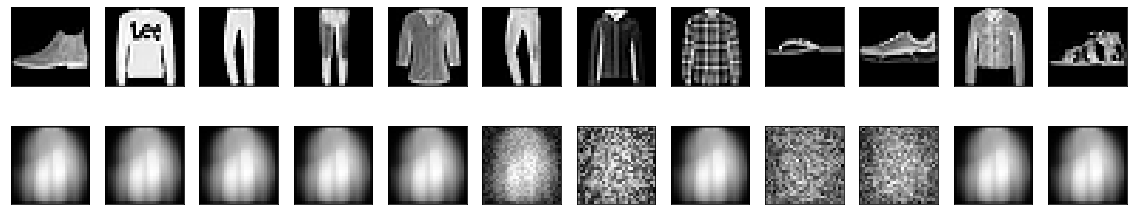

In [37]:
number_of_items = 12 # how many items we will display
plt.figure(figsize=(20, 4))
for i in range(number_of_items):
# display items before compression
    graph = plt.subplot(2, number_of_items, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    graph.get_xaxis().set_visible(False)
    graph.get_yaxis().set_visible(False)
    # display items after decompression
    graph = plt.subplot(2, number_of_items, i + 1 + number_of_items)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    graph.get_xaxis().set_visible(False)
    graph.get_yaxis().set_visible(False)
plt.show()

### Denoising autoencoder

In [4]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 1

In [3]:
import tensorflow
tensorflow.__version__

'2.0.0-alpha0'

In [107]:
(train_x,_),(test_x,_) = fashion_mnist.load_data()

In [108]:
train_x,test_x=np.reshape(train_x.astype('float32')/255,(-1,28,28,1)),np.reshape(test_x.astype('float32')/255,(-1,28,28,1))

In [109]:
train_x.shape

(60000, 28, 28, 1)

In [110]:
noise = 0.5
train_x_noisy = train_x + noise * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape)
test_x_noisy = test_x + noise * np.random.normal(loc=0.0, scale=1.0, size=test_x.shape)

In [111]:
np.clip(train_x_noisy,0,1).min()

0.0

In [112]:
train_x_noisy= np.clip(train_x_noisy,0,1)
test_x_noisy=np.clip(test_x_noisy,0,1)

In [113]:
%matplotlib inline

In [114]:
number_of_items=10

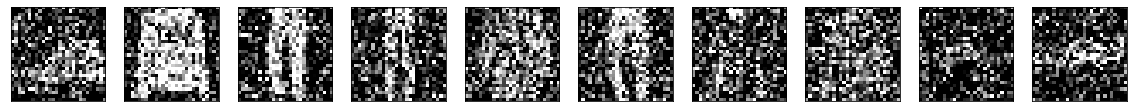

In [115]:
plt.figure(figsize=(20, 2))

for i in range(number_of_items):
    display = plt.subplot(1, number_of_items,i+1)
    plt.imshow(test_x_noisy[i].reshape(28, 28))
    plt.gray()
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

In [134]:
train_x_noisy.shape

(60000, 28, 28, 1)

In [135]:
input_image = Input(shape=(28, 28, 1))
im = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_image)
im=MaxPooling2D(pool_size=(2,2),padding='same')(im)
im=Conv2D(32,(3,3),activation='relu',padding='same')(im)
encoded=MaxPooling2D(pool_size=(2,2),padding='same')(im)
encoded

<tf.Tensor 'max_pooling2d_16/MaxPool:0' shape=(None, 7, 7, 32) dtype=float32>

In [136]:
im=Conv2D(32,kernel_size=(3,3),padding='same',activation='relu')(im)

In [137]:
im=UpSampling2D()(im)
im

<tf.Tensor 'up_sampling2d_7/ResizeNearestNeighbor:0' shape=(None, 28, 28, 32) dtype=float32>

In [138]:
decoded=Conv2D(1,kernel_size=(3,3),activation='sigmoid',padding='same')(im)
decoded

<tf.Tensor 'conv2d_32/Sigmoid:0' shape=(None, 28, 28, 1) dtype=float32>

In [139]:
autoencoder=Model(inputs=input_image,outputs=decoded)


In [161]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0005)

In [162]:
autoencoder.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])

In [163]:
if os.path.isdir("logs"):
    print('already there')
else:
    os.mkdir("logs")

already there


In [164]:
logdir = "logs"
tensorboard_callback = [TensorBoard(log_dir=logdir)]

In [165]:
epochs=3
batch_size=512

In [166]:
autoencoder.fit(x=train_x_noisy,y=train_x,epochs=epochs,batch_size=batch_size,verbose=True,validation_split=0.1,callbacks=tensorboard_callback)

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 47s 863us/sample - loss: 0.2966 - accuracy: 0.5079 - val_loss: 0.2983 - val_accuracy: 0.5040
Epoch 2/3
54000/54000 [==============================] - 50s 925us/sample - loss: 0.2961 - accuracy: 0.5080 - val_loss: 0.2982 - val_accuracy: 0.5040
Epoch 3/3
54000/54000 [==============================] - 52s 959us/sample - loss: 0.2960 - accuracy: 0.5080 - val_loss: 0.2980 - val_accuracy: 0.5040


In [167]:
decoded_images = autoencoder.predict(test_x_noisy)
number_of_items = 10

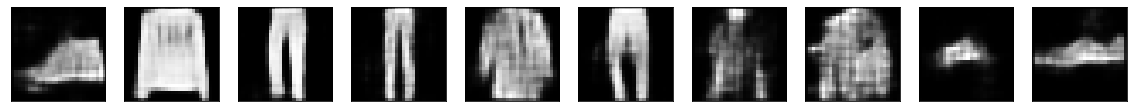

In [168]:
plt.figure(figsize=(20, 2))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = decoded_images[item].reshape(28, 28)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()